In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

sys.path.insert(1, os.path.join(sys.path[0], ".."))
from reproduction.pipeline.load import load_data
from reproduction import analysis
import sklearn
from scipy.stats import wasserstein_distance

In [86]:
import seaborn

In [2]:
# open/closed cell data dir
CLOSEDATADIR="/home/tkurihana/scratch-midway2/clouds/"
CLOSEDS = "/closed.tfrecord"
OPENDATADIR="/home/tkurihana/scratch-midway2/clouds/"
OPENS = "/open.tfrecord"

# outputdata dir
OUTPUTDIR="/project/foster/clouds/output"
CENTERS = OUTPUTDIR+"/mod09cnn15b/encodings/m15b-enc.cluster_centres"
ENCODER_DEF = OUTPUTDIR+"/mod09cnn15b/encoder.json"
ENCODER_WEIGHTS = OUTPUTDIR+"/mod09cnn15b/encoder-585000.h5"
ENCODINGS = OUTPUTDIR+"/mod09cnn15b/encodings/m15b-enc"

In [3]:
centers = analysis.read_kmeans_centers(CENTERS)

In [4]:
k = KMeans(n_clusters=centers.shape[0], init=centers)

In [5]:
with open(ENCODER_DEF,"r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(ENCODER_WEIGHTS)

In [19]:
def _classifier(encoder, keyward, opendir, openfile, closeddir, closedfile, num_of_file):
    OPENS   = opendir+keyward+"_open"+openfile
    CLOSEDS = closeddir+keyward+"_close"+closedfile
    
    # TODO: debug
    def decode_tfrecord(OUTPUT_TFRECORD_NAME):
        count = 0
        imgs = []
        print(OUTPUT_TFRECORD_NAME)
        for record  in tf.python_io.tf_record_iterator(OUTPUT_TFRECORD_NAME):
            count += 1
    
        print(count)
        return count
    # get file number
    no = decode_tfrecord(OPENS)
    nc = decode_tfrecord(CLOSEDS)
    print(no, nc)
    _N  = min(no, nc) 
    N   = min(num_of_file, _N ) # min(no, nc) -1 # get less number  32 is largest??
    print(N)
    
    ## Repeat off and set reasonable n (patch) number
    opens = analysis.AEData(load_data(OPENS, encoder.input_shape[1:], repeat=False), n=N)
    closeds = analysis.AEData(load_data(CLOSEDS, encoder.input_shape[1:], repeat=False), n=N)  
    #  encoder 
    opens.add_encoder(encoder)
    closeds.add_encoder(encoder)
    #  cluster
    k.cluster_centers_ = centers
    #
    both = np.append(opens.encs,closeds.encs, axis=0)
    num_clusters = 10
    method = SpectralClustering(n_clusters=num_clusters, affinity="nearest_neighbors")
    clusters = method.fit_predict(both)
    o, c = clusters[:N], clusters[N:]
    #o = 1 ; c = 1
    return o, c

In [18]:
o, c = _classifier(encoder,'2017JAN03MOD09GA', OPENDATADIR, OPENS, CLOSEDATADIR, CLOSEDS, 32)

/home/tkurihana/scratch-midway2/clouds/2017JAN03MOD09GA_open/open.tfrecord
17
/home/tkurihana/scratch-midway2/clouds/2017JAN03MOD09GA_close/closed.tfrecord
77
17 77
10


OutOfRangeError: End of sequence
	 [[Node: IteratorGetNext_12 = IteratorGetNext[output_shapes=[[32], [32,2], [32,128,128,7]], output_types=[DT_STRING, DT_INT64, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator_12)]]

Caused by op 'IteratorGetNext_12', defined at:
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-3a6f19abfb47>", line 1, in <module>
    o, c = _classifier(encoder,'2017JAN03MOD09GA', OPENDATADIR, OPENS, CLOSEDATADIR, CLOSEDS, 32)
  File "<ipython-input-17-a927dfbb5563>", line 28, in _classifier
    opens = analysis.AEData(load_data(OPENS, encoder.input_shape[1:], repeat=False), n=N)
  File "../reproduction/analysis.py", line 38, in __init__
    batch = dataset.make_one_shot_iterator().get_next()
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 373, in get_next
    name=name)), self._output_types,
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1745, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

OutOfRangeError (see above for traceback): End of sequence
	 [[Node: IteratorGetNext_12 = IteratorGetNext[output_shapes=[[32], [32,2], [32,128,128,7]], output_types=[DT_STRING, DT_INT64, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator_12)]]


In [86]:
keylist = ['2017JAN01MOD09GA', '2017JAN02MOD09GA', '2017JAN03MOD09GA', '2017JAN04MOD09GA']

In [87]:
# TODO: debug
def _decode_tfrecord(OUTPUT_TFRECORD_NAME):
        count = 0
        imgs = []
        print(OUTPUT_TFRECORD_NAME)
        for record  in tf.python_io.tf_record_iterator(OUTPUT_TFRECORD_NAME):
            count += 1
            #xample = tf.train.Example()
            #xample.ParseFromString(record) # Read binary data
        #rint(example)
    
        print(count)
        #print(height, width, depth)
        return count

In [92]:
# get file number
for i in range(4):
    opendir    = OPENDATADIR
    openfile   = OPENS
    closeddir  = CLOSEDATADIR
    closedfile = CLOSEDS
    keyward = keylist[i]

    _OPENS   = opendir+keyward+"_open"+openfile
    _CLOSEDS = closeddir+keyward+"_close"+closedfile
    no = _decode_tfrecord(_OPENS)
    nc = _decode_tfrecord(_CLOSEDS)
    print(no, nc)

/home/tkurihana/scratch-midway2/clouds/2017JAN01MOD09GA_open/open.tfrecord
38
/home/tkurihana/scratch-midway2/clouds/2017JAN01MOD09GA_close/closed.tfrecord
38
38 38
/home/tkurihana/scratch-midway2/clouds/2017JAN02MOD09GA_open/open.tfrecord
6
/home/tkurihana/scratch-midway2/clouds/2017JAN02MOD09GA_close/closed.tfrecord
29
6 29
/home/tkurihana/scratch-midway2/clouds/2017JAN03MOD09GA_open/open.tfrecord
17
/home/tkurihana/scratch-midway2/clouds/2017JAN03MOD09GA_close/closed.tfrecord
77
17 77
/home/tkurihana/scratch-midway2/clouds/2017JAN04MOD09GA_open/open.tfrecord
28
/home/tkurihana/scratch-midway2/clouds/2017JAN04MOD09GA_close/closed.tfrecord
5
28 5


In [20]:
def _dirname(keyward, opendir, openfile, closeddir, closedfile):
    OPENS   = opendir+keyward+"_open"+openfile
    CLOSEDS = closeddir+keyward+"_close"+closedfile
    return OPENS , CLOSEDS

In [21]:
fopen, fclose = _dirname('2017JAN03MOD09GA', OPENDATADIR, OPENS, CLOSEDATADIR, CLOSEDS)

In [22]:
fopen

'/home/tkurihana/scratch-midway2/clouds/2017JAN03MOD09GA_open/open.tfrecord'

In [39]:
# size of patches for using
N = 30

In [40]:
## Repeat off and set reasonable n (patch) number
#opens = analysis.AEData(load_data(fopen, encoder.input_shape[1:], repeat=False), n=N)
closeds = analysis.AEData(load_data(fclose, encoder.input_shape[1:], repeat=False), n=N)  
#  encoder 
#opens.add_encoder(encoder)
closeds.add_encoder(encoder)

In [59]:
fopen, fclose = _dirname('2017JAN03MOD09GA', OPENDATADIR, OPENS, CLOSEDATADIR, CLOSEDS)

In [61]:
# size of patches for using
N = 10

In [62]:
## Repeat off and set reasonable n (patch) number
opens = analysis.AEData(load_data(fopen, encoder.input_shape[1:], repeat=False), n=N)
#closeds = analysis.AEData(load_data(fclose, encoder.input_shape[1:], repeat=False), n=N)  
#  encoder 
opens.add_encoder(encoder)
#closeds.add_encoder(encoder)

In [63]:
#  cluster
k.cluster_centers_ = centers

In [64]:
both = np.append(opens.encs,closeds.encs, axis=0)
num_clusters = 10
method = SpectralClustering(n_clusters=num_clusters, affinity="nearest_neighbors")
clusters = method.fit_predict(both)
o, c = clusters[:10], clusters[10:]

In [66]:
# Probability you correctly classify open vs closed given cluster assignments
# Over N = 10, correctness works fine by T. Kurihana
correctness = 0
for i in range(10):
    # Add one open and closed cell to every class to increase uncertainty
    # in clusters with few examples
    n_open = np.where(o == i)[0].shape[0] #+ 1
    n_clos = np.where(c == i)[0].shape[0] #+ 1
    n_clus = n_open + n_clos
    #print('n_clus == ', n_clus, 'open and close %d' %(n_open , n_clos))
    
    prob_open = n_open / n_clus
    correctness += n_clus * max(prob_open, 1 - prob_open)
    
correctness /= 60  # 30 + 30 ??
correctness  # hybrid ration 1/100% means totally separeted <==> 0/0% means totally same 

0.6166666666666667

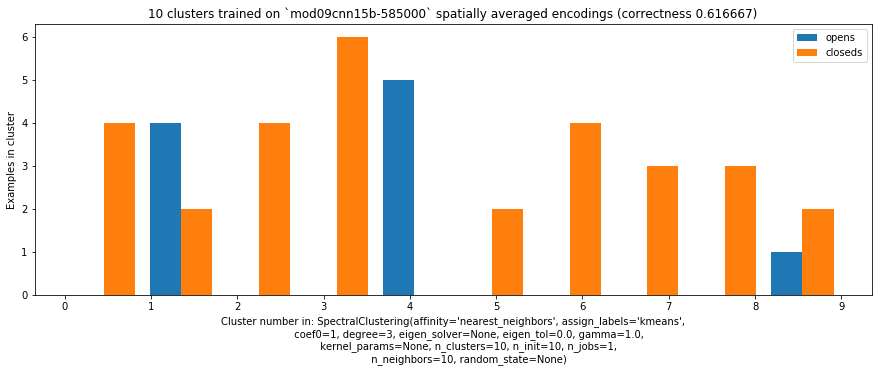

In [67]:
plt.figure(figsize=(15, 5))
plt.hist([o,c], bins=num_clusters, label=["opens", "closeds"])
plt.xlabel("Cluster number in: "+str(method))
plt.xticks(range(num_clusters))
plt.ylabel("Examples in cluster")
plt.title("%d clusters trained on `mod09cnn15b-585000` spatially averaged encodings (correctness %f)"%(num_clusters, correctness))
plt.legend()

In [69]:
fopen, fclose = _dirname('2017JAN01MOD09GA', OPENDATADIR, OPENS, CLOSEDATADIR, CLOSEDS)

In [70]:
## Repeat off and set reasonable n (patch) number
N = 30
opens = analysis.AEData(load_data(fopen, encoder.input_shape[1:], repeat=False), n=N)
closeds = analysis.AEData(load_data(fclose, encoder.input_shape[1:], repeat=False), n=N)  
#  encoder 
opens.add_encoder(encoder)
closeds.add_encoder(encoder)

In [72]:
both = np.append(opens.encs,closeds.encs, axis=0)
num_clusters = 10
method = SpectralClustering(n_clusters=num_clusters, affinity="nearest_neighbors")
clusters = method.fit_predict(both)
o_1, c_1 = clusters[:30], clusters[30:]

In [75]:
# Combine x + x_1
_o = [o, o_1]
_c = [c, c_1]

In [68]:
def cluster_distribution(cluster_labels):
    # return count
    distribution = np.unique(cluster_labels, return_counts=True)[1]
    return distribution/distribution.sum()

In [82]:
o_distributions = []
c_distributions = []
for i, j in zip(_o, _c):
    o_distributions += [ cluster_distribution(i)]
    c_distributions += [ cluster_distribution(j)]

In [83]:
o_distributions

[array([0.4, 0.5, 0.1]),
 array([0.03333333, 0.26666667, 0.23333333, 0.2       , 0.16666667,
        0.1       ])]

In [84]:
c_distributions

[array([0.13333333, 0.06666667, 0.13333333, 0.2       , 0.06666667,
        0.13333333, 0.1       , 0.1       , 0.06666667]),
 array([0.23333333, 0.16666667, 0.3       , 0.2       , 0.1       ])]

/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return u

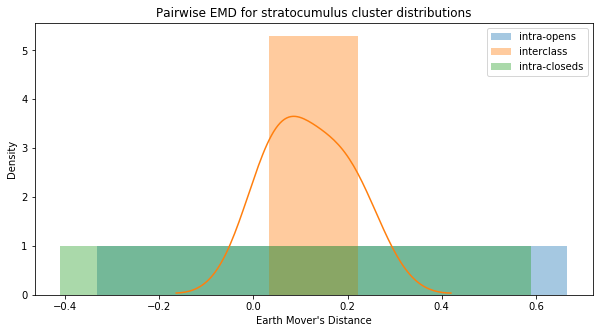

In [87]:
ds = {}
ds["intra-opens"]   = [wasserstein_distance(x,y) for x in o_distributions for y in o_distributions if x is not y]
ds["interclass"]    = [wasserstein_distance(x,y) for x in o_distributions for y in c_distributions if x is not y]
ds["intra-closeds"] = [wasserstein_distance(x,y) for x in c_distributions for y in c_distributions if x is not y]

plt.figure(figsize=(10, 5))
for i, h in ds.items():
    seaborn.distplot(h, label=i, norm_hist=True)
plt.ylabel("Density")
plt.xlabel("Earth Mover's Distance")
plt.title("Pairwise EMD for stratocumulus cluster distributions")
plt.legend()

In [88]:
for i, h in ds.items():
    print(i)
    print(h)

intra-opens
[0.16666666666666669, 0.16666666666666669]
interclass
[0.22222222222222227, 0.15111111111111114, 0.06666666666666667, 0.033333333333333326]
intra-closeds
[0.08888888888888889, 0.08888888888888889]


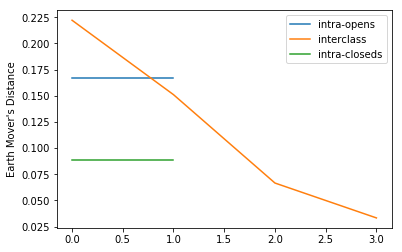

In [92]:
for i, h in ds.items():
    plt.plot(h, label=i)
plt.ylabel("Earth Mover's Distance")
plt.legend()

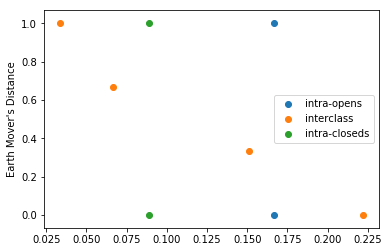

In [99]:
for i, h in ds.items():
    _y = np.linspace(0,1,len(h))
    plt.scatter(h,_y, label=i)
plt.ylabel("Earth Mover's Distance")
plt.legend()